# Clustering - Session / Workshop

"Clustering" refers to a number of algorithms that can identify structures within a dataset, i.e. concentrations of datapoints or overdensities. 
 
Clustering is an **unsupervised learning** technique, meaning prior knowledge of the clusters (e.g. number, properties) is needed. However, it is possible to use a labelled training sample to calibrate the hyperparameters.

## 1. Clustering algorithms overview

In this session we will present a broad overview of classification algorithms.
We will first showcase a set of **sklearn** algorithms, and then describe most of them.

The rest are left for the student to study or experiment during the following workshop section.

In [16]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import warnings
warnings.filterwarnings(action='once')

In [17]:
# GENERATE TOY DATASET

from sklearn import datasets

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

In [18]:
# SETTING UP CLUSTERING PARAMETERS

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

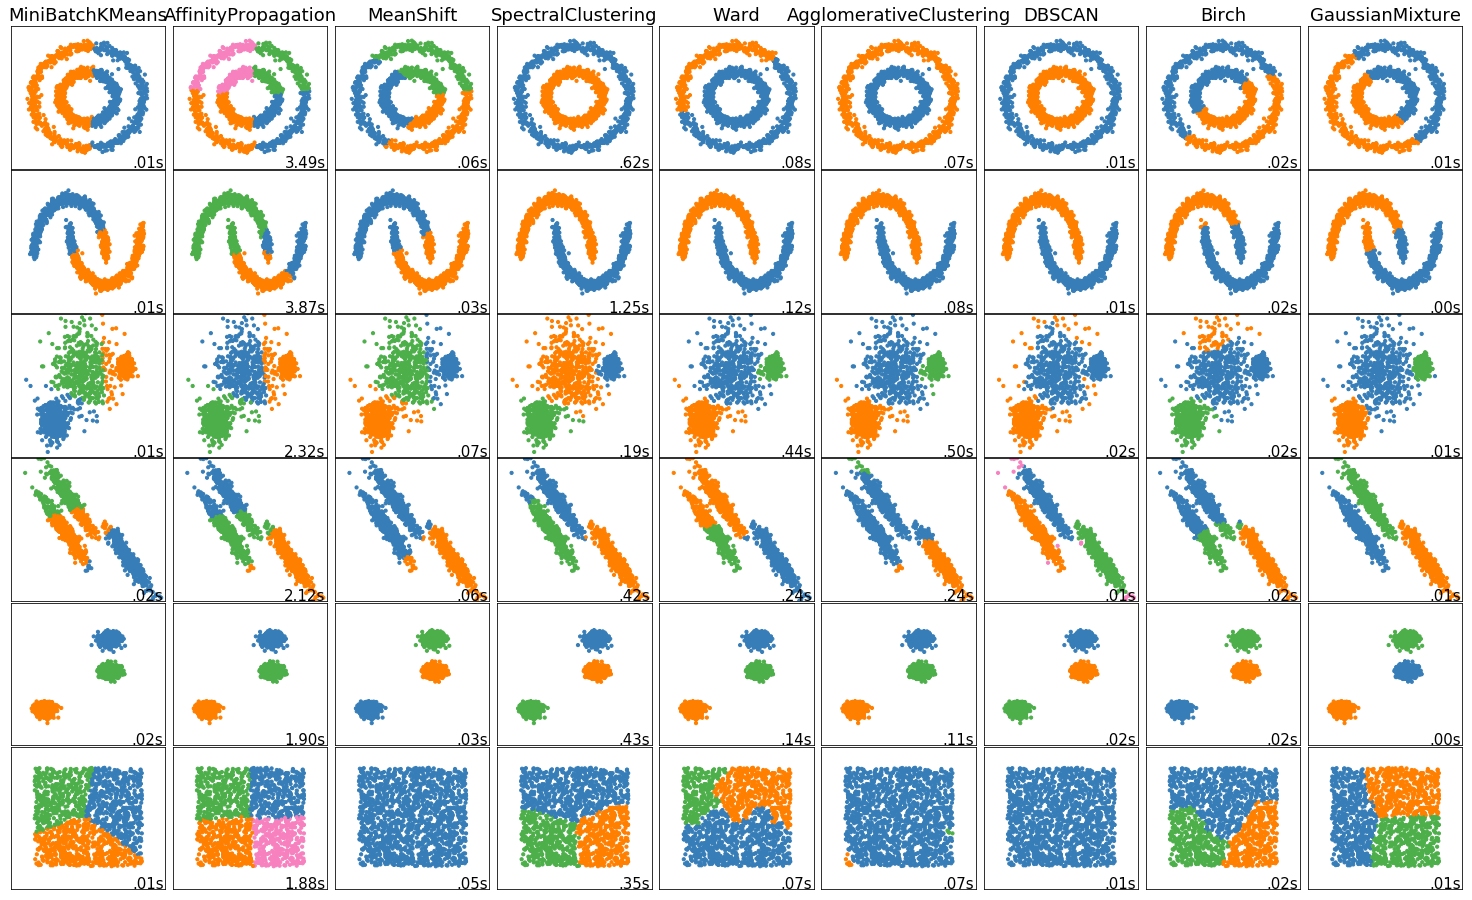

In [19]:
# RUNNIG CLUSTERING ALGORITHMS

import time

from sklearn.neighbors import kneighbors_graph
from sklearn import cluster, mixture
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1


for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1


plt.show()

The showcase above is reproduced from **sklearn**. For more info, see:
http://scikit-learn.org/stable/modules/clustering.html

The last dataset is an example of a 'null' situation for clustering: the data is homogeneous, and there is no good clustering. 

Important take-home points:

> * Not all the algorithms identify the same number of clusters
> * Some algorithms are more sensitive to parameter values than others
> * Some algorithms cannot guess the number of clusters, but only find them
> * Some algorithms can be faster
> * Same algorithms are not computationally efficient with large samples
> * The intuitive clustering might not apply to very high dimensional data

### How do they separate the clusters?

Tipically, clustering algorithms use 2 types of hyperparamters:

> * The properties of the data themselves
    <br>
    _e.g. density of points (minimum number of points and the area), distance between points, etc._
> * The number of clusters
    <br>
    _might be provided by the user or dinamically derived_

## 2. Algorithm: K-means

The K-means algorithm tries to partition a sample of N observations (with each observation being a $d$-dimensional vector) into $k$ individual clusters $C_k$. The goal is to minimize the within-cluster sum-of-squares (or **inertia**) of the observations:

$$min \left (  \sum_{k=1}^{K} \sum_{i \epsilon C_k} ||x_i-\mu_k||^2 \right )$$

where $\mu_k=\frac{1}{N_k}\sum_{i \epsilon C_k} x_i$ is the mean/centroid of the $N_k$ points included in each of the $C_k$ clusters. 

<table><tr>
    <td width=400>
        <img src="images/kmeans.gif">
        <center>
            <br>
            Figure 2. Evolution of K-means centroids through iterations.
            <br>
            (From [here](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/))
        </center>
    </td>
</tr></table>

**Steps**:
1. Initiate algorithm by selecting $k$ means
<br>
*e.g. select randomly $k$ observations as initial means - see also [Wiki:K-means initialization](http://en.wikipedia.org/wiki/K-means_clustering#Initialization_methods)*
2. Assign each observation to the nearest cluster
3. Calculate the new mean value for each cluster $C_k$ according to the new observations assiged
4. Repeat steps 2 and 3 up to the point that there are no updates in the assigments to the clusters.

A globally optimal minimum is not guaranteed (might converge to a local minimum). This is highly dependent on the initialization of the centroids. This is why, in practice, K-means is run multiple times with different starting values selecting the result with the lowest sum-of-squares error. To improve on that we can initially select centrodis that are generally distant from each other. See more [here](https://www.jeremyjordan.me/grouping-data-points-with-k-means-clustering/).

#### Complexity

$O(knT)$, where k, n and T are the number of clusters, samples and iterations, respectively.

### Pros

- Simple and intuitive

### Cons

- The number of clusters (K) must be provided (or cross-validated)
- There is an inherit assumption of isotropic clusters
- Inertia is not a normalized metric: lower values are better , but as the dimensions increase so does the inertia

### 2.1 Mini Batch K-means

For faster computations the sklearn offers the [Mini Batch K-means](http://scikit-learn.org/stable/modules/clustering.html#mini-batch-kmeans) method which simply breaks the initial set of observations/data points to smaller randomly selected subsamples.

For each subsample in the mini batch the assigned centroid is updated by taking into account the average of that subsample and all previous subsamples assigned to that centroid. This is prepeated until the predefined number of iterations is reached. Its results are generally only slightly worset then the standard algorithm.

## 3. Algorithm: Mean Shift

Mean Shift identifies arbitrarily shaped clusters (blobs) by locating the peaks of a density estimate of the data.

**Steps:**

The algorithm iteratively shifts the centroid of a cluster "climbing" the peak of the density distribution of the nearby data points: this is effectively a "gradient search". But how to define the "shape" of the gradient? The assumed distribution is given by a local convolution between the data and a kernel function, e.g. Gaussian:

> $K(x_i-x)=e^{-c||x_i-x||^2}$) 

where $x_i$ is sample $i$ and $x$ is the cluster centroid.
Apart from the kernel function, the user must also define a neighborhood $N(x)$ over which to estimate the density (also called **bandwith** $h$).
This implicitly sets the number of K of clusters which will be found.

In practice, at each iteration the algorithm calculates a **mean shift** vector which tells where to re-place the cluster center:

> $m(x)-x$

where $m(x)$ is the new expected centroid, calculated as:

$$m(x)=\frac{ \sum_{x_i\epsilon N(x)}K(x_i-x)x_i}{\sum_{x_i\epsilon N(x)}K(x_i-x)}$$.

The search stops when the update in the centroid is below some threshold.

<table><tr>
    <td width=300>
        <img src="images/mean_shift.gif">
        <center>
            <br>
            Figure 3. Evolution of a Mean Shift centroid through iterations.
            The centroid "climbs" towards the center of the density distribution.
            <br>
            (From [here](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/))
        </center>
    </td>
</tr></table>

#### Complexity

$O(Tn^{2})$, where n and T are the number of samples and iterations, respectively.

### Pros

- Guaranteed to converge

### Cons

- The number of clusters implicitly set
- There is an inherit assumption of isotropic clusters
- Computationally expensive

## 4. Hierarchical Clustering

This type of clustering groups points by ranking them **bottom-up** (agglomerative) or **top-down** (divisive). It merges close points into clusters based on the distance between them.

### 4.1. Agglomerative Clustering

This is an example of the **bottom-up** case.

**Steps:**

1. Initiate with K$_{clusters}$ = N$_{points}$
2. Calculate the distances between all the pairs of points
3. Iteratively connect the nearest pairs of points until obtaining a single cluster
<br>
_(see the dendrogram below)_
4. Merge all clusters below a threshold, which could be:
    - a given number of clusters (stop at K clusters)
    - a given separation

<table><tr>
    <td width=350>
        <img src="images/dendogram.png">
        <center>
            <br>
            Figure 4.1.a. Construction of dendogram and application of decision threshold.
        </center>
    </td>
    <td width=400>
        <img src="images/hierarchical.gif">
        <center>
            <br>
            Figure 4.1.b.Construction of dendogram for Hierarchical Clustering.
            <br>
            (From [here](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/))
        </center>
    </td>
</tr></table>

#### Type of  point linking for Agglomerative Clustering

For additional complexity, one can chose other solutions other than the pair-wise coupling of points.

<tr><table>
    <td width=400>
        <img src="images/cluster_distances.png">
        <center>
            <br>
            Figure 4.2.Type of point linking for Agglomerative Clustering.
            <br>
            (From [here](https://www.youtube.com/watch?v=VMyXc3SiEqs))
        </center>
    </td>
</tr></table>

#### Complexity

$O(n^2 d + n^3)$, where n and T are the number of samples and iterations, respectively (very slow).

## 5. Algorithm: DBSCAN
**(Density Based Spatial Clustering of Applications with Noise)**

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density.
Thus, clusters found by DBSCAN can be any shape - as opposed to other algorithms (K-means for example) which assume that clusters are convex shaped.

It uses 2 parameters:
* $eps$ : neighborhood size
* $minPts$ : minimum number of points for a neighborhood to be considered dense

<table><tr>
    <td width=350>
        <img src="images/dbscan.png">
        <center>
            <br>
            Figure 5.1.a. Definition of **core**, **border**, and **noise** points, according to DBSCAN.
        </center>
    </td>
    <td width=400>
        <img src="images/dbscan-smiley.gif">
        <center>
            <br>
            Figure 5.1.b.DBSCAN constructing clusters.
            <br>
            (From [here](http://arogozhnikov.github.io/images/opera/post/clustering-dbscan-smiley.gif))
        </center>
    </td>
</tr></table>

With 1 scan we can label the points as: **core**, **border**, **noise**. How?

-  A point $p$ is defined **core** if at least $minPts$ points are within the area defined by $eps$
-  A **border** point is a non-core point that has at least 1 core point in its neighborhood
-  A **noise** point is neither a core nor a border point. There represent outliers in the data set

Defined these, DBSCAN operates as follows.

#### Steps:

1. Algorithm picks 1 unassigned core point ($p_c$)
2. Let $p_c$ be the current point being explored
3. Add all points ($q$) of $p_c$’s neighborhood to the same cluster
4. Some of these $q$ points are also core points so: recursively apply this search on each unexplored core point of this neighborhood
5. When all neighbourhood points have been joined, DBSCAN proceeds with a new cluster

Process ends when all core points have been assigned to a cluster

### Pros
- Any number of clusters
- Clusters of varying size and shape
- Finds and ignores outliers

### Cons
- Relatively slow
- Extremely sensitive to parameters choice
- In rare cases, border points move to an other cluster when DBSCAN is re-run
- Serious troubles with clusters with varying density
  <br>
  _(OPTICS and HDBSCAN are variations which address this problem)_

## 6. Summary
| Algorithm                | fixed n$_{clusters}$ ? |
| :----------------------: | :--: |
| KMeans                   | yes  |
| Mean Shift               | implicitly |
| Agglomerative Clustering | yes or no |
| DBSCAN                   | no |


## A. EXERCISE: Classify Star-forming objects in a BPT diagram

The "Baldwin, Phillips & Terlevich" (BPT) diagrams are used to distinguish sources based on specific spectral emission lines. The strengths of these lines depend on the heating source.
See e.g.: https://ned.ipac.caltech.edu/level5/Glossary/Essay_bpt.html

BPTs allow to distinguish:
> - AGNs (Seyfert)
> - LINERs
> - Star-forming galaxies
> - Composite objects

<table><tr>
    <td width=600>
        <img src="images/BPT.png" width=600>
        <center>
            <br>
            Figure A. Example of classification via BPT diagram.
            Theoretical or observationally-calibrated curves allow to distinguish
            the different sub-populations.
            <br>
            (From [Parra et al. (2010), ApJ, 720, 555](https://ui.adsabs.harvard.edu/abs/2010ApJ...720..555P/abstract))
        </center>
    </td>
</tr></table>


### The sample

We will use the data by [Stampoulis et al. (2019), MNRAS, 485, 1085](https://ui.adsabs.harvard.edu/abs/2019MNRAS.485.1085S/abstract), which provides the OIII, NII, SII, and OI diagnostics for ~130 000 objects.

The work also gives classifications, which we will use as a reference.

### TASK A.1: Find the best clustering algorithm for separating star-forming objects

### TASK A.2: Plot results and check consistency with BPT theoretical curves

### Loading and setting up the data

In [20]:
# CREATING DATA STRUCTURE

# > Loading the emission line data and classifications from Stampoulis+19:

PATH_Stampoulis_data = "data/Stampoulis+19_Table_2.csv"

data = np.genfromtxt(PATH_Stampoulis_data, delimiter=",")
# The data file is organized in 138799 lines (i.e. different objects), and 12 columns

# To check file dimensions:
# print(data.shape)

ID               = data[:,0]  # object ID
NII_diagnostic   = data[:,3]  # log10 ( NII_6584  / H_alpha )
SII_diagnostic   = data[:,4]  # log10 ( SII_6717  / H_alpha )
OI_diagnostic    = data[:,5]  # log10 ( OI        / H_alpha )
OIII_diagnostic  = data[:,6]  # log10 ( OIII_5007 / H_beta )

labels = np.genfromtxt(PATH_Stampoulis_data, delimiter=',', usecols=-1, dtype=str)
# reading labels from last column
# Activity class labelling scheme:
#   0 <-> SFG (Star Forming Galaxy)
#   1 <-> SEY (Seyfert)
#   2 <-> LIN (LINER)
#   3 <-> COM (Composite)

# Dictionary containg class name and associated label:
from collections import OrderedDict
classes = OrderedDict()
classes["SFG"] = 0
classes["SEY"] = 1
classes["LIN"] = 2
classes["COM"] = 3

labels = [int(float(label)) for label in labels]
# converting labels from strings to integers

# > Organizing data in an analysis-ready fashion:
X_sample = np.stack((OIII_diagnostic,NII_diagnostic,SII_diagnostic,OI_diagnostic),axis=-1)
y_sample = labels

We will Use only 1 every <sampling_factor> objects for two reasons:

> - to speed up the exercise
> - to avoid crashes due to memory limitations.

You can try to use the full sample when confident with the setup (and your computer power!).

In [21]:
# SUGGESTION: Use only 1 every <sampling_factor> objects 

sampling_factor = 50
# sample 1 every <sampling_factor> data to avoid computational delay

X = X_sample[::sampling_factor]
y = y_sample[::sampling_factor]

print('Sample shape:')
print("_____________________________________")
print('  X  | ' + str(X.shape))
print('     | ' + str(X.shape[0]) + ' sammples x ' + str(X.shape[1]) + ' diagnostics' )
print("-----|-------------------------------")
print('  y  | ' + str(len(y)) + ' labels')

Sample shape:
_____________________________________
  X  | (2616, 4)
     | 2616 sammples x 4 diagnostics
-----|-------------------------------
  y  | 2616 labels


Although available, we will not use the labels for the analysis, but only for the first representation of the data.

### Visualizing the data
Essentially reproducing Figure 5 in Stampoulis+19

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


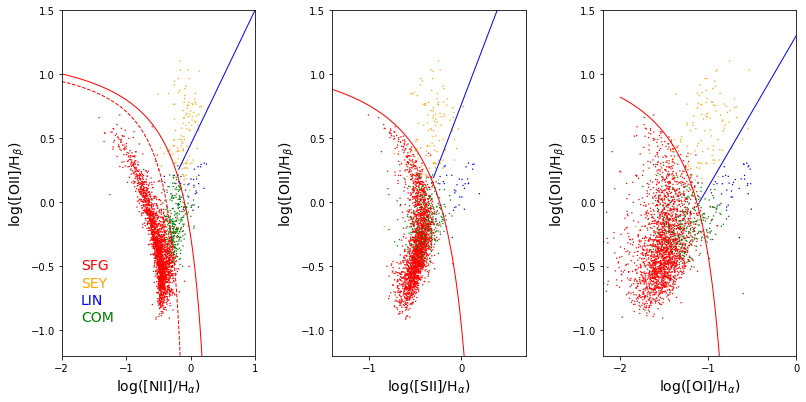

In [23]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors

# Limit scatter plots (not histograms) in showing a maximum of <N_plot> objects:
# for full sample size, use: N_plot = len(X)
N_plot = 5000
# NOTE: reducing the sample in the plot helps visualizing the density

# Creating a colormap where:
#   red    <-> SFG
#   yellow <-> SEY
#   blue   <-> LIN
#   green  <-> COM
cmap = mpl.colors.ListedColormap(['red','orange','blue','green'])

# Remeber that the sample X is organized as:
#  X[:,0] <-> OIII_diagnostic
#  X[:,1] <-> NII_diagnostic
#  X[:,2] <-> SII_diagnostic
#  X[:,3] <-> OI_diagnostic


# PLOT THE DIAGNOSITCS

# > Classification lines
#   NII:
x1 = np.linspace(-2, 0.05, 100)
x2 = np.linspace(-2, 0.47, 100)
x3 = np.linspace(-0.1839, 1)
ke01_NII = 0.61 / (x1-0.05) + 1.3   # Kewley+01
ka03_NII  = 0.61 / (x2-0.47) + 1.19 # Kuffmann+03
sc07_NII  = 1.05 * x3 + 0.45        # Schawinski+07
#   SII:
x4 = np.linspace(-2, 0.05, 100)
x5 = np.linspace(-0.3, 1)
ke01_SII  = 0.72 / (x4-0.32) + 1.3  # Kewley+01
ke06_SII  = 1.89 * x5 + 0.76        # Kewley+06
#   OI:
x6 = np.linspace(-2, -0.8, 100)
x7 = np.linspace(-1.1, 0)
ke01_OI = 0.72 / (x6+0.59) + 1.33  # Kewley+01
ke06_OI = 1.18 * x7 + 1.30         # Kewley+06

fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.4)

ylim = [-1.2,1.5] # OIII_diagnostic range

# > left plot

xlim = [-2,1] # NII_diagnostic range

ax = fig.add_subplot(131)
im = ax.scatter(X[:, 1], X[:, 0], c=y, s=2, lw=0, cmap=cmap, zorder=2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.set_xlabel('log([NII]/H$_{α})$', fontsize=14)
ax.set_ylabel('log([ΟII]/H$_{β})$', fontsize=14)
#
ax.plot(x1, ka03_NII, "--", color='red',  linewidth = 1.0, label='Ka03')
ax.plot(x2, ke01_NII, "-",  color='red',  linewidth = 1.0, label='Ke01')
ax.plot(x3, sc07_NII, "-",  color='blue', linewidth = 1.0, label='Sc07')

# legend:
ax.text(0.1,0.25, "SFG", color='red',    transform=ax.transAxes, fontsize=14)
ax.text(0.1,0.20, "SEY", color='orange', transform=ax.transAxes, fontsize=14)
ax.text(0.1,0.15, "LIN", color='blue',   transform=ax.transAxes, fontsize=14)
ax.text(0.1,0.10, "COM", color='green',  transform=ax.transAxes, fontsize=14)

# > central plot

xlim = [-1.4,0.7] # SII_diagnostic range

ax = fig.add_subplot(132)
im = ax.scatter(X[-N_plot:, 2], X[-N_plot:, 0], c=y[-N_plot:], s=2, lw=0, cmap=cmap, zorder=2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.set_xlabel('log([SII]/H$_{α})$', fontsize=14)
ax.set_ylabel('log([ΟII]/H$_{β})$', fontsize=14)
#
ax.plot(x4, ke01_SII, "-",  color='red',  linewidth = 1.0, label='Ke01')
ax.plot(x5, ke06_SII, "-",  color='blue', linewidth = 1.0, label='Ke06')


# > right plot

xlim = [-2.2,0.0] # OI_diagnostic range

ax = fig.add_subplot(133)
im = ax.scatter(X[-N_plot:, 3], X[-N_plot:, 0], c=y[-N_plot:], s=2, lw=0, cmap=cmap, zorder=2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.set_xlabel('log([OI]/H$_{α})$', fontsize=14)
ax.set_ylabel('log([ΟII]/H$_{β})$', fontsize=14)
#
ax.plot(x6, ke01_OI, "-",  color='red',  linewidth = 1.0, label='Ke01')
ax.plot(x7, ke06_OI, "-",  color='blue', linewidth = 1.0, label='Ke06')

plt.show()

# NOTE: Ignore the warning, due to the plotting of the lines

### RESPONSE TO A.1 and A.2: Running clustering algorithms and plotting

In [ ]:
import time

from sklearn.neighbors import kneighbors_graph
from sklearn import cluster, mixture
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

plt.figure(figsize=(9 * 2 + 3, 8))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

params = {'quantile': ...,
            'eps': ...,
            'damping': ...,
            'preference': ...,
            'n_neighbors': ...,
            'n_clusters': ...}

# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    X, n_neighbors=params['n_neighbors'], include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# ============
# Create cluster objects
# ============
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
k_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
ward = cluster.AgglomerativeClustering(
    n_clusters=params['n_clusters'], linkage='ward',
    connectivity=connectivity)
average_linkage = cluster.AgglomerativeClustering(
    linkage="average", affinity="cityblock",
    n_clusters=params['n_clusters'], connectivity=connectivity)
complete_linkage = cluster.AgglomerativeClustering(
    linkage="complete", affinity="cityblock",
    n_clusters=params['n_clusters'], connectivity=connectivity)
spectral = cluster.SpectralClustering(
    n_clusters=params['n_clusters'], eigen_solver='arpack',
    affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=params['eps'])
affinity_propagation = cluster.AffinityPropagation(
    damping=params['damping'], preference=params['preference'])
birch = cluster.Birch(n_clusters=params['n_clusters'])
gmm = mixture.GaussianMixture(
    n_components=params['n_clusters'], covariance_type='full')

clustering_algorithms = (
    ('MiniBatchKMeans', k_means),
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm)
)

# restoring normalization for plotting
X_plot = X_sample[::sampling_factor]

for name, algorithm in clustering_algorithms:
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)
        
    plt.subplot(1, len(clustering_algorithms), plot_num)
    plt.title(name, size=18)

    plt.plot(x1, ka03_NII, "--", color='grey',  linewidth = 1.0, label='Ka03')
    plt.plot(x2, ke01_NII, "-",  color='grey',  linewidth = 1.0, label='Ke01')
    plt.plot(x3, sc07_NII, "-",  color='grey', linewidth = 1.0, label='Sc07')
    
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    plt.scatter(X_plot[:, 2], X_plot[:, 0], s=2, color=colors[y_pred])
    plt.scatter(X_plot[y_pred==-1,2], X_plot[y_pred==-1,0], s=100, facecolors='none', edgecolors='black', color='black', label='background', alpha=0.1, zorder=0)
    # marking background class for DBSCAN

    plt.gca().set_xlim(-2,1)     # NII_diagnostic range
    plt.gca().set_ylim(-1.2,1.5) # OIII_diagnostic range

    plt.xticks(np.arange(xlim[0], xlim[1], step=1))
    plt.yticks(np.arange(ylim[0], ylim[1], step=0.5))

    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plot_num += 1


plt.show()

### Q: Which algorithm performs best?
[+] click to discover

[//]: # "
The Ward algorithm seems to be the best in separating Star-Forming Galaxies.

Other algorithms (e.g. Affinity Propagation) might be considered valid if we join some clusters.
"

## B. EXERCISE: Count stellar clusters

In [Bitsakis, Bonfini et al. (2017), ApJ, 845, 56]( https://ui.adsabs.harvard.edu/abs/2017ApJ...845...56B/abstract) we describe a technique for the detection of star clusters in the Large Magellanic Cloud. The basic step for the cluster detection was converting the observed images into pixel-maps, where each star was represented by a single pixel.

In this exercise we use clustering algorithms to detect clusters in simulated stellar fields, which we already to pixel-maps. Each pixel-map includes an arbitrary (unknown to the student) number of clusters. The first 3 images present increasing noise levels. One last map has been smoothed to simulate observational data.

### TASK B.1: Guess the number of stellar clusters in the provided images using cluster algorithms


### Loading and visualizing the data


All black pixels have a value of 0
All white pixels have a value of 999


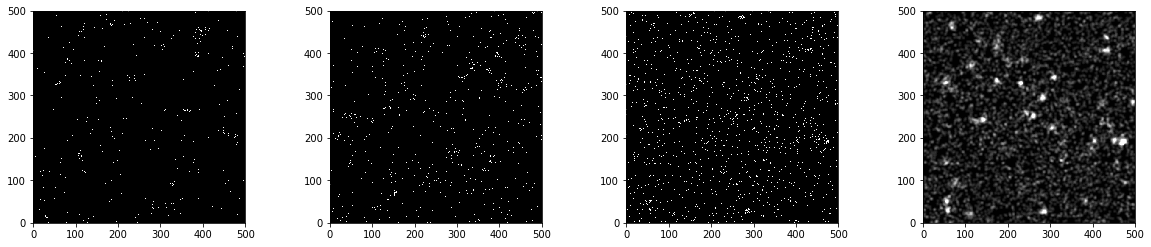

In [11]:
from matplotlib import pyplot as plt

# FITS manipulation:
from astropy.io import fits

PATH_cluster_files = [
    "data/clusters_0.fits",
    "data/clusters_1.fits",
    "data/clusters_2.fits",
    "data/clusters_2_smooth.fits"]

# > Loading fits files:
image_data = []

for i, PATH_cluster_file in enumerate(PATH_cluster_files):

    hdulist = fits.open(PATH_cluster_file)
    image_data.append(hdulist[0].data)
    hdulist.close()

# > Displaying fits files:    
fig = plt.figure(figsize=(18, 10))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.4)

for i in range(len(PATH_cluster_files)):

    ax = plt.subplot(1, 4, int(i+1))  
    ax.imshow(image_data[i], cmap='gray', vmin=-1, vmax=0.5*np.max(image_data[i]), origin='lower')

print('All black pixels have a value of %s' % int(np.min(image_data[0])))
print('All white pixels have a value of %s' % int(np.max(image_data[0])))

### Setting up the data

Image data/clusters_0.fits shape | (1591, 2)
Image data/clusters_1.fits shape | (2811, 2)
Image data/clusters_2.fits shape | (6136, 2)
Image data/clusters_2_smooth.fits shape | (4263, 2)

NOTE: These are not images of stars: they only represent the positions of the stars.
Therefore, we will only be using the (x,y) position of the stars (not the pixel "intensity").


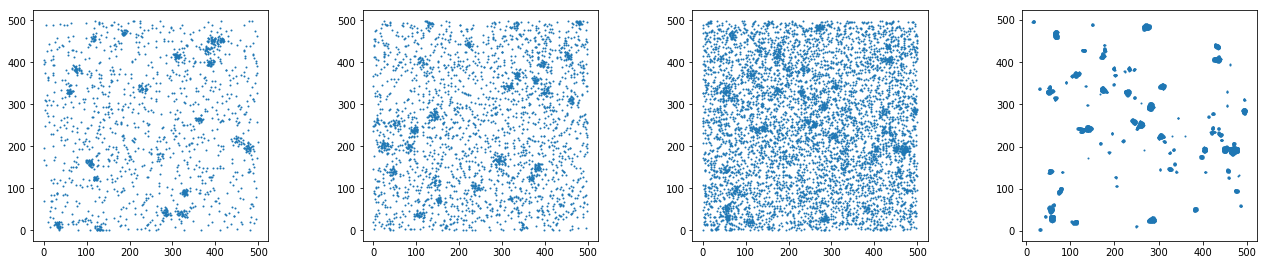

In [12]:
# CONVERTING FROM IMAGE FORMAT TO STANDARD FORMAT FOR CLASSIFIER

'''
The image shape loaded with fits.open() is:
    <n_pixels, n_pixels>
where each element represents an image row (intensity_1, intensity_2, ... , intensity_n).
We will convert this to the more convenient shape:
    X = <n_pixels^2, 3>
where each element represents a single pixel (x, y, intensity).
This is the format used by clustering algorithms.
'''

datasets = []
# list containing all images

for i, PATH_cluster_file in enumerate(PATH_cluster_files):

    x = np.arange(image_data[i].shape[1])
    y = np.arange(image_data[i].shape[0])
    # NOTE: python inverts i with j index
    xx, yy = np.meshgrid(x, y)

    X_image = np.array([xx.ravel(), yy.ravel(), image_data[i].ravel()]).T

    X_image = X_image[X_image[:,2]!=0]
    # removing background pixels (i.e. pixels with flux == 0)
    # NOTE: noise pixels are still in the sample!
    
    if(PATH_cluster_file == "data/clusters_2_smooth.fits"):
    # NOTE: For the smoothed image, we will apply a background thershold or else
    #       too many data points will be used and the clustering algorithms will
    #       crash due to memory limitations.
        X_image = X_image[X_image[:,2]>100]
    
    # After dealing with background, now going back to 2D (x, y):
    X_image = X_image[:,0:2]
    # NOTE: We will only be using the (x,y) position of the stars (not the pixel "intensity"
    
    print("Image " + str(PATH_cluster_file) + " shape | " + str(X_image.shape))
        
    datasets.append(X_image)
    
# > Displaying new image format:
fig = plt.figure(figsize=(20, 4))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.4)

for i in range(len(PATH_cluster_files)):

    X_image = datasets[i]
    
    ax = plt.subplot(1, 4, int(i+1))  
    ax.scatter(X_image[:,0],X_image[:,1], s=1)
    
print('\nNOTE: These are not images of stars: they only represent the positions of the stars.')
print('Therefore, we will only be using the (x,y) position of the stars (not the pixel "intensity").')    

### RESPONSE TO B.1: Guessing the number of stellar clusters in the provided images using cluster algorithms
HINT: To speed up the procedure, you might want to comment out the algorithms which use a fixed number of clusters

In [ ]:
import time

from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

plt.figure(figsize=(9 * 2 + 3, 16))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': ...,
                'eps': ...,
                'damping': ...,
                'preference': ...,
                'n_neighbors': ...,
                'n_clusters': ...,
                'threshold':...}

for i_dataset, dataset in enumerate(datasets):
    params = default_base.copy()

    X = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=None, linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(
        n_clusters=params['n_clusters'],threshold=params['threshold'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch)
        ('GaussianMixture', gmm)
    )

    print("> %-30s" % PATH_cluster_files[i_dataset])

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
        plt.scatter(X[y_pred==-1,0], X[y_pred==-1,1], s=100, facecolors='none', edgecolors='black', color='black', label='background', alpha=0.1, zorder=0)
        # marking background class for DBSCAN

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

        
        n_clusters_ = len(set(y_pred)) - (1 if -1 in y_pred else 0)
        n_noise_    = list(y_pred).count(-1)

        print("  %-25s | n_clusters %-3s | n_noise points %-3s" % (name, n_clusters_, n_noise_))


plt.show()

### See "Clustering_SW_answerkey.ipynb" to discover actual number of clusters

### Q: Which algorithm performs best?
[+] click to discover

[//]: # "
DBSCAN seems the most efficient, especially for the non-smoothed images. This is because it is able to deal with the noise (not by chance, DBSCAN is the acronym for "Density-Based Spatial Clustering of Applications _with Noise_").

Additional post-clustering processing (e.g. rejecting clusters with a small number of samples), can further improve the results.

The detection is more problematic when pixel get smoothed (as in real images). Check Bitsakis, Bonfini et al. (2017) for a technique to deal with detection in observational data.
"

### Q: Should  we be _also_ using the 3rd dimension, i.e. the pixel intensity?
[+] click to discover

[//]: # "
In this case no. Because all pixels have the same value (999), therefore the pixels will appear all "clustered"  in the 3D dimension. This would make harder the separation of clusters.
"

## C. EXERCISE: Separate stellar types 

The equivalent widths (EQWs) of the HeII 4200 line and HeI 4471 line can be used to separate stellar spectral types. The first one is a good indicator of **O-type** stars while the second is stronger in **early B-type** stars. The absence of both characterizes late **B-type stars**
For more details see [Maravelias (2014), PhD thesis](http://skinakas.physics.uoc.gr/en/research/theses/GrMaraveliasPhD.pdf).

### The sample
 
From [Evans et al. (2004)](http://adsabs.harvard.edu/abs/2004MNRAS.353..601E) we selected a sample of OB stars (697) having HeII 4200 and HeI 4471 line measurements.

### TASK C.1: Use K-means (or MiniBatchKMeans) to separate the 3 stellar classes

### TASK C.2: Plot results and highlight cluster centers

### Loading and visualizing the data

In [13]:
import sys
from collections import defaultdict

def flospecConv(arg):
	"""
	Function to convert from spectral types to 
	float numbers (e.g. B0,O9.5 to 20.0,19.5)
	and backwards.
	""" 
	try:
		float(arg)
		if str(arg)[0]=='1':
			sp = 'O'
		elif str(arg)[0]=='2':
			sp = 'B'
		elif str(arg)[0]=='3':
			sp = 'A'
		else:
			sys.exit(' ! ERROR: more than O/B stars! Adjust conversion function.')
		new_arg = sp+str(arg)[1:]
	except ValueError:
		if arg[0]=='O' or arg[0]=='o':
			fl = '1'
		elif arg[0]=='B' or arg[0]=='b':
			fl = '2'
		elif arg[0]=='A' or arg[0]=='a':
			fl = '3'
		else:
			sys.exit(' ! ERROR: Check input! If more than O/B stars adjust conversion function.')
		new_arg = float(arg.replace(arg[0],fl))

	return new_arg

# Reading the data file:

PATH_data = "data/stellar_types.dat"

stars=defaultdict(list)
with open(PATH_data,'r') as inf:
    for line in inf:
        if line[0]!='#':
            cols = line.split()
            item = cols[0]
            spline = cols[1]
            if spline=='HeI/4471':
                ewHeI = cols[2]
                stars[item].append(ewHeI)
            elif spline=='HeII/4200':
                ewHeII = cols[2]
                stars[item].append(ewHeII)

# Creating data structures:

sptype, flosptype, ewHeI, ewHeII = [], [], [], []
for s in stars.keys():
    sptype.append(s.split('-')[0])
    flosptype.append(flospecConv(s.split('-')[0]))
    ewHeII.append(float(stars[s][0]))
    ewHeI.append(float(stars[s][1]))
    
# > Organizing data in an analysis-ready fashion:
X = np.column_stack((ewHeII,ewHeI))

print('Sample shape:')
print("___________________________________")
print('  X  | ' + str(X.shape))
print('     | ' + str(X.shape[0]) + ' sammples x ' + str(X.shape[1]) + ' diagnostics' )

Sample shape:
___________________________________
  X  | (697, 2)
     | 697 sammples x 2 diagnostics


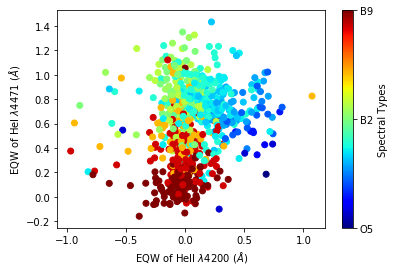

In [14]:
# PLOTTING

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

scat = plt.scatter(ewHeII, ewHeI, c=flosptype, edgecolors='face', cmap="jet")
cb = plt.colorbar(scat, ticks=[15,22,29])   # range of available spectral types
cb.set_ticklabels(['O5','B2','B9'])
cb.set_label('Spectral Types')

plt.ylabel(r"EQW of HeI $\lambda$4471 ($\AA$)")
plt.xlabel(r"EQW of HeII $\lambda$4200 ($\AA$)")
plt.show()

### RESPONSE TO C.1 and C.2: Running clustering algorithm and plotting
HINT: Check **sklearn** documentation for [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to know how to easily retrieve the cluster centers 

In [ ]:
Clusters_kmeans = ...
from sklearn.cluster import KMeans

kmeans = ...

print("Cluster centers:")

cc_x = kmeans. ...
cc_y = kmeans. ...

plt.plot(cc_x, cc_y, 'k+', ms=100)

new_map = matplotlib.cm.gray.from_list('whatever', ('blue', 'red'), N=Clusters_kmeans)
scat2 = plt.scatter(ewHeII, ewHeI, c=kmeans.labels_, edgecolors='face', cmap=new_map)
cb = plt.colorbar(scat2, ticks=range(0,Clusters_kmeans+1,1))   # number of clusters
cb.set_ticklabels(range(1,Clusters_kmeans+2,1))
cb.set_label('Cluster Label')

plt.ylabel(r"EQW of HeI $\lambda$4471 ($\AA$)")
plt.xlabel(r"EQW of HeII $\lambda$4200 ($\AA$)")

plt.show()